---

# Анализ данных в Pandas

---

## 1 | Немного о природе данных

---

Импортируем библиотеки и загрузим данные:

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/content/sample_data/avito_flats.csv', sep=';', index_col=0)
print(df.columns)

Index(['id', 'Город', 'Район', 'Улица', 'Геометка_дома', 'Тип_сделки',
       'Срок_аренды', 'Цена', 'Тип_дома', 'Количество_комнат', 'Общая_площадь',
       'Количество_этажей', 'Материал_стен', 'Тип_продажи', 'Дата',
       'Площадь_кухни', 'Жилая_площадь', 'Этаж'],
      dtype='object')


---

### 1.2 | Описательные статистики

Узнаем среднюю площадь квартир по количеству комнат с кирпичными стенами:

In [3]:
df[df['Материал_стен'] == 'кирпичный'] \
    .groupby('Количество_комнат') \
    .agg({'Общая_площадь': 'mean'})

,Общая_площадь
Количество_комнат,
1,38.907625
2,61.601440
3,93.072085
4,120.500000
5,230.100000
своб. планировка,58.000000
студия,26.714849


---

### 1.3 | Предобработка данных

---

Заменим все ячейки со значением 'Не указано' на $\mathsf{np.nan}$, преобразуем такие строки с ценой, как '9 616 960' к '9616960', а также преобразуем все численные данные к типу $\mathsf{np.float64}$:

In [4]:
df = df.replace('Не указано', np.nan)
df['Цена'] = df['Цена'].str.replace(' ', '')

df = df.astype({'Цена': np.float64, 'Общая_площадь': np.float64,
                'Площадь_кухни': np.float64, 'Жилая_площадь': np.float64})
df['Жилая_площадь'].head()

0    12.2
1    27.0
2     NaN
3    24.4
4    37.7
Name: Жилая_площадь, dtype: float64

---

Рассмотрим уникальные значения некоторых колонок, чтобы отсеять бесполезные признаки:

In [5]:
df['Тип_сделки'].unique()

array(['Продажа'], dtype=object)

In [6]:
df['Срок_аренды'].unique()

array(['Не аренда'], dtype=object)

In [7]:
df['Тип_дома'].unique()

array(['Новостройка'], dtype=object)

In [8]:
df['Количество_этажей'].unique()

array([nan])

In [9]:
df['Тип_продажи'].unique()

array([nan])

In [10]:
df['Район'].value_counts(dropna=False)

NaN                     6616
Приморский район           2
Красносельский район       1
Name: Район, dtype: int64

In [11]:
df = df.drop(['Тип_сделки', 'Срок_аренды', 'Тип_дома',
              'Количество_этажей', 'Тип_продажи', 'Район'], axis=1)
df.columns

Index(['id', 'Город', 'Улица', 'Геометка_дома', 'Цена', 'Количество_комнат',
       'Общая_площадь', 'Материал_стен', 'Дата', 'Площадь_кухни',
       'Жилая_площадь', 'Этаж'],
      dtype='object')

---

Также могут встречаться и те признаки, у которых не практически все значения пропущены. Например, такие, как 'Жилая_площадь' и 'Площадь кухни':

In [12]:
df['Жилая_площадь'].size, df['Жилая_площадь'].isna().sum()

(6619, 1904)

In [13]:
df['Площадь_кухни'].size, df['Площадь_кухни'].isna().sum()

(6619, 2545)

Такие колонки можно и выкинуть, и наоборот — заполнить пропущенные места какими-то значениями. Давайте для разнообразия заполним пропущенные значения медианами:

In [14]:
df['Жилая_площадь'] = df['Жилая_площадь'].fillna(df['Жилая_площадь'].median())
df['Площадь_кухни'] = df['Площадь_кухни'].fillna(df['Площадь_кухни'].median())

---

## 3 | Обработка и первичный анализ

---

### 3.1 | Группировка и аггрегация

---

С помощью группировки и аггрегации мы может, например, ращбить квартиры по материалу стен и посмотреть на медиану площадей для каждого из классов:

<Axes: xlabel='Материал_стен'>

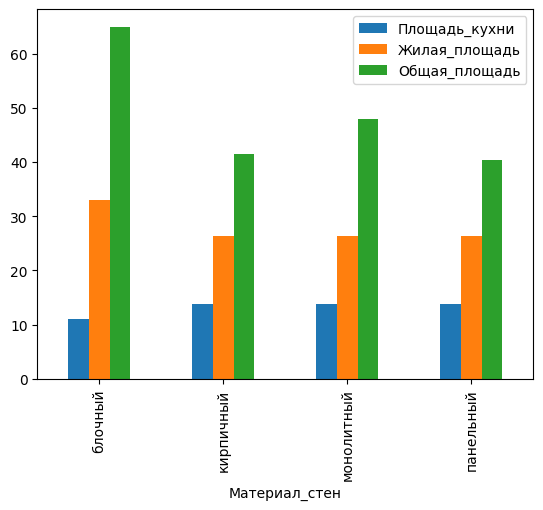

In [15]:
df.groupby('Материал_стен').agg({
    'Площадь_кухни': 'median',
    'Жилая_площадь': 'median',
    'Общая_площадь': 'median'
}).plot.bar()

---

Нам может захотеться построить гистограммы цен по каждому из материалов стен, тогда мы можем в методе построения диаграммы указать такой параметр, как $\mathsf{by}$:

array([[<Axes: title={'center': 'блочный'}, ylabel='Frequency'>,
        <Axes: title={'center': 'кирпичный'}, ylabel='Frequency'>,
        <Axes: title={'center': 'монолитный'}, ylabel='Frequency'>,
        <Axes: title={'center': 'панельный'}, ylabel='Frequency'>]],
      dtype=object)

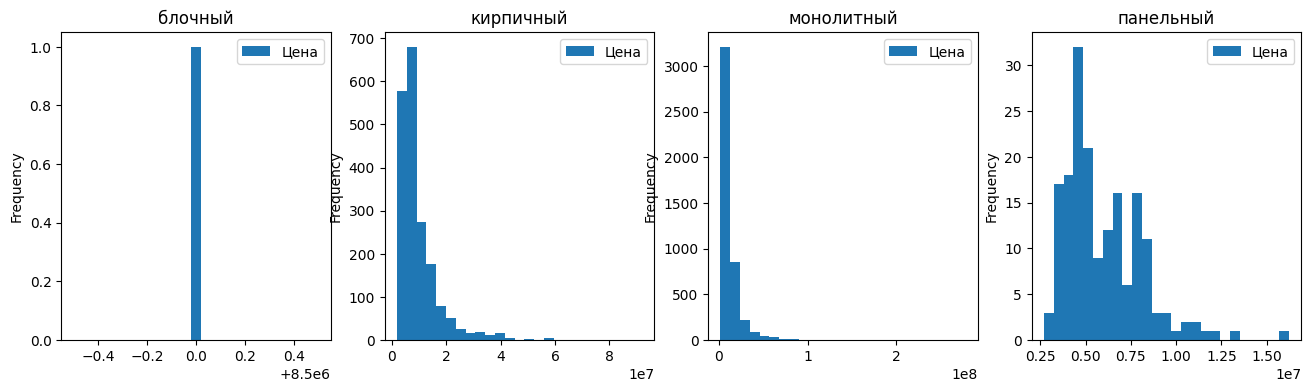

In [16]:
df[['Цена', 'Материал_стен']].plot.hist(
    by='Материал_стен', bins=25, figsize=(16, 4), layout=(1, 4))

Как мы видим, у панельных квартир есть нет единого пика — их несколько. Может, это из-за количества комнат? Давайте исследуем:

array([[<Axes: title={'center': '1'}, ylabel='Frequency'>,
        <Axes: title={'center': '2'}, ylabel='Frequency'>,
        <Axes: title={'center': '3'}, ylabel='Frequency'>,
        <Axes: title={'center': '4'}, ylabel='Frequency'>,
        <Axes: title={'center': 'студия'}, ylabel='Frequency'>]],
      dtype=object)

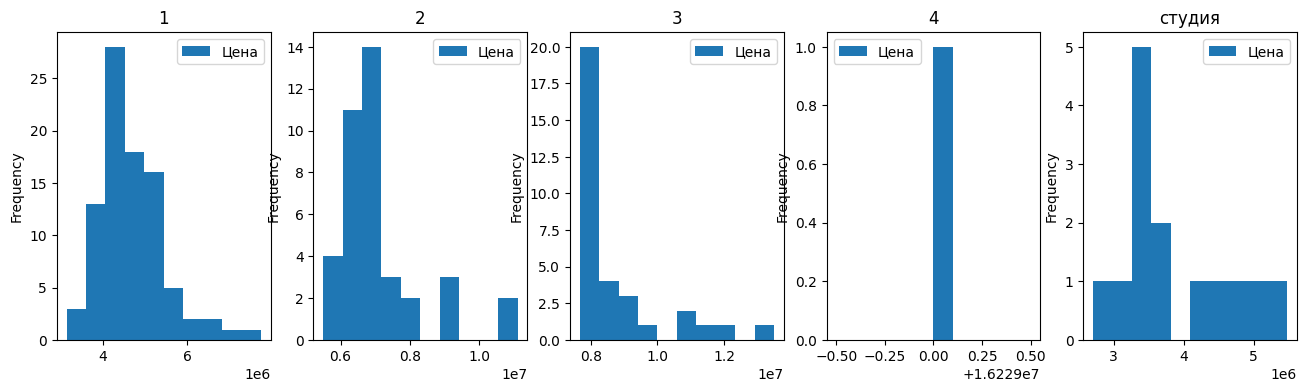

In [17]:
df[df['Материал_стен'] == 'панельный'][
    ['Количество_комнат', 'Цена']].plot.hist(
    by='Количество_комнат', bins=10,
    figsize=(16, 4), layout=(1, -1))

---

## 3.2 | Слияние фреймов

---

Бывает так, что связанные между собой данные хранятся в двух файлах или таблицах. Например, как в нашем случае, метаинформация хранится в файле 'avito_flats_meta.csv':

In [18]:
meta_df = pd.read_csv('/content/sample_data/avito_flats_meta.csv', sep='*', index_col=0)
meta_df.columns

Index(['id', 'Фото', 'Описание'], dtype='object')

Но как слить наши данные во что-то одно? Есть несколько способов слияния таблиц:

- Внутренее (inner)
- Слева (left)
- Справа (right)
- Внешнее (outer)

![](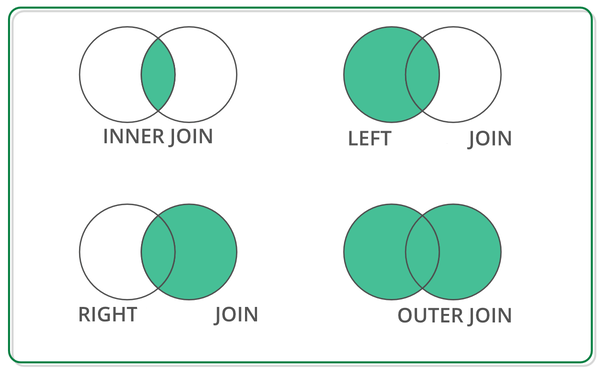 )

---

Итак, давайте сольем наши таблицы по колонке 'id' в одну, используя inner join. Для этого существует метод $\mathsf{merge}$ с его параметрами $\mathsf{left\_on}$, $\mathsf{right\_on}$ и $\mathsf{inner}$:

In [19]:
df.merge(meta_df, left_on='id', right_on='id', how='inner') \
    .isna().any()

id                   False
Город                False
Улица                 True
Геометка_дома        False
Цена                 False
Количество_комнат    False
Общая_площадь        False
Материал_стен        False
Дата                 False
Площадь_кухни        False
Жилая_площадь        False
Этаж                 False
Фото                 False
Описание             False
dtype: bool

In [20]:
df.merge(meta_df, left_on='id', right_on='id', how='left') \
    .isna().any()

id                   False
Город                False
Улица                 True
Геометка_дома        False
Цена                 False
Количество_комнат    False
Общая_площадь        False
Материал_стен        False
Дата                 False
Площадь_кухни        False
Жилая_площадь        False
Этаж                 False
Фото                  True
Описание              True
dtype: bool

In [21]:
df.merge(meta_df, left_on='id', right_on='id', how='right') \
    .isna().any()

id                   False
Город                 True
Улица                 True
Геометка_дома         True
Цена                  True
Количество_комнат     True
Общая_площадь         True
Материал_стен         True
Дата                  True
Площадь_кухни         True
Жилая_площадь         True
Этаж                  True
Фото                 False
Описание             False
dtype: bool

In [22]:
df.merge(meta_df, left_on='id', right_on='id', how='outer') \
    .isna().any()

id                   False
Город                 True
Улица                 True
Геометка_дома         True
Цена                  True
Количество_комнат     True
Общая_площадь         True
Материал_стен         True
Дата                  True
Площадь_кухни         True
Жилая_площадь         True
Этаж                  True
Фото                  True
Описание              True
dtype: bool

---

Давайте в итоге используем inner join:

In [23]:
df = df.merge(meta_df, left_on='id', right_on='id', how='inner')
df.columns

Index(['id', 'Город', 'Улица', 'Геометка_дома', 'Цена', 'Количество_комнат',
       'Общая_площадь', 'Материал_стен', 'Дата', 'Площадь_кухни',
       'Жилая_площадь', 'Этаж', 'Фото', 'Описание'],
      dtype='object')